### Goal

In this notebook, we take a look at how you can run tuning analysis on your model and obtain measures commonly used in visual neuroscience. As our model we will use some example V1-like RFs obtained from [Taylor et al. 2024](https://www.biorxiv.org/content/10.1101/2024.05.12.593763v1#:~:text=We%20found%20that%20the%20model,prediction%20of%20the%20sensory%20future.).

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from brainbox import tuning

%load_ext autoreload
%autoreload 2

In [2]:
tuning_path = "data/tuning"

In [3]:
gabor_rfs = torch.load(f"data/gabor_rfs.pt")  # Load our example spatial RFs (shape: units x height x width)
model = gabor_rfs.unsqueeze(1).repeat(1, 10, 1, 1)  # shape: unit x time x height x width

In [4]:
def nicify(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel("Signal (a.u.)", fontsize=14, labelpad=2)
    ax.set_xlabel("Time (s)", fontsize=14, labelpad=2)

In [5]:
torch.manual_seed(42)
probe_ms = 3000  # Probe for 3s
dt = 1000 / 120

def input_to_response(data):
    with torch.no_grad():
        # data shape: batch x time x height x width
        response = F.conv3d(data.unsqueeze(1), model.unsqueeze(1).cuda())
        return torch.relu(response[:, :, :, 0, 0])  # batch x units x time (responses should be in this shape)
    
thetas = np.linspace(0, np.pi*2, 72)
spatial_freqs = np.around(np.linspace(0.01, 0.2, 10), 4)
temporal_freqs = [1, 2, 4, 8]

gratings = tuning.GratingsProber(input_to_response, amplitude=1, rf_w=20, rf_h=20, duration=probe_ms*dt, dt=dt, thetas=thetas, spatial_freqs=spatial_freqs, temporal_freqs=temporal_freqs)
gratings.probe_and_fit(tuning_path, probe_batch=128, response_batch=32)

INFO:root:Probing the model...
INFO:root:Obtaining all unit responses to optimal gratings...


In [6]:
# Let's load up our tuning results and take a look at what we got!
query = tuning.TuningQuery(tuning_path)
optimal_response = torch.load(f"{tuning_path}/unit_responses.pt")

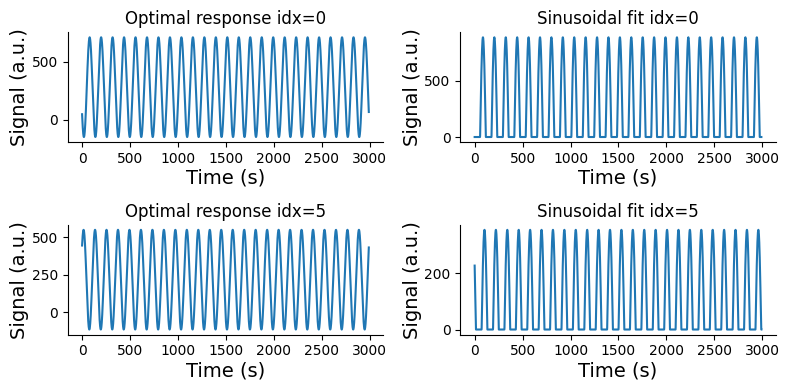

In [7]:
#### We can view the optimal response (i.e. when the unit is most active) and the corresponding 
# sinusoidal fit (which is used to calculate the F1/F0 measure)
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
for i, neuron_idx in enumerate([0, 5]):
    axs[i, 0].plot(query.build_sinusoid_from_spectral(i))
    axs[i, 1].plot(optimal_response[neuron_idx])
    nicify(axs[i, 0])
    nicify(axs[i, 1])
    axs[i, 0].set_title(f"Optimal response idx={neuron_idx}")
    axs[i, 1].set_title(f"Sinusoidal fit idx={neuron_idx}")
    fig.tight_layout()

In [8]:
# We can query all the tuning parameters like so
tuning_df = query.validate(response_threshold=0.1, fit_threshold=0.0)
tuning_df

,mean_response,fit_cc,theta,sf,tf,OSI,DSI,F1F0
0,280.869537,0.888606,4.424778,0.0100,1.0,0.003403,0.000025,1.529087
1,218.221771,0.891599,3.362832,0.1578,1.0,0.836448,0.004391,1.518719
2,177.891678,0.892267,6.194690,0.1578,1.0,0.506336,0.012615,1.519024
3,126.539742,0.890827,0.442478,0.0733,1.0,0.152299,0.003833,1.519715
4,344.269043,0.892203,1.592920,0.0100,1.0,0.003084,0.005363,1.518906
...,...,...,...,...,...,...,...,...
136,179.252304,0.888666,3.097345,0.1789,1.0,0.776370,0.005746,1.527775
137,48.009998,0.892336,0.973451,0.1578,1.0,0.525402,0.005941,1.519551
138,144.049835,0.892129,0.265487,0.1367,1.0,0.335111,0.015466,1.518909
139,138.429062,0.892263,1.327434,0.0522,1.0,0.122135,0.005236,1.519044


array([[<AxesSubplot: title={'center': 'mean_response'}>,
        <AxesSubplot: title={'center': 'fit_cc'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'sf'}>,
        <AxesSubplot: title={'center': 'tf'}>,
        <AxesSubplot: title={'center': 'OSI'}>],
       [<AxesSubplot: title={'center': 'DSI'}>,
        <AxesSubplot: title={'center': 'F1F0'}>, <AxesSubplot: >]],
      dtype=object)

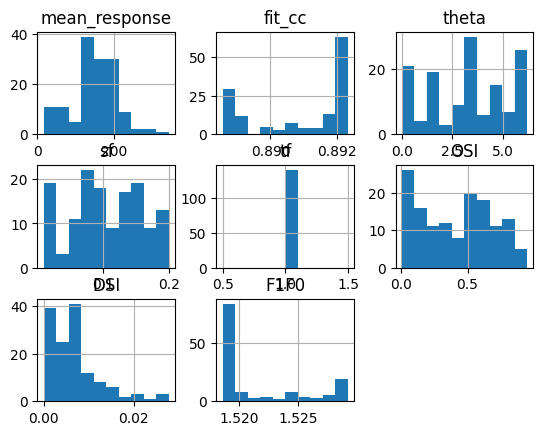

In [9]:
tuning_df.hist()  # let's view a summary of all of the parameter distributions

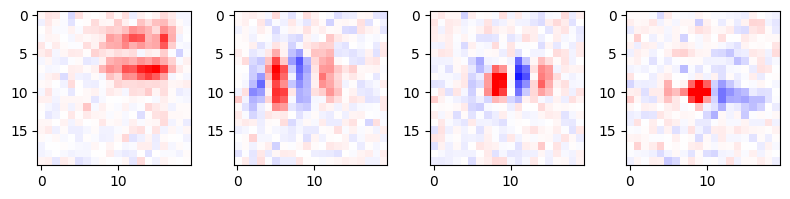

In [10]:
# Let's view some of the RFs of our model
fig, axs = plt.subplots(1, 4, figsize=(8, 16))
axs[0].imshow(gabor_rfs[0], cmap="bwr", vmin=-3, vmax=3)
axs[1].imshow(gabor_rfs[1], cmap="bwr", vmin=-3, vmax=3)
axs[2].imshow(gabor_rfs[2], cmap="bwr", vmin=-3, vmax=3)
axs[3].imshow(gabor_rfs[3], cmap="bwr", vmin=-3, vmax=3)
fig.tight_layout()

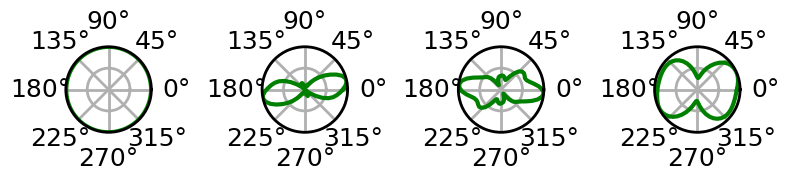

In [11]:
# Let's see what the corresponding orientation tuning curves of those RFs look like

def plot_orientation_tuning(unit_idx, ax):
    theta, tuning_curve = query.orientation_tuning_curve(unit_idx)
    ax.plot(theta, tuning_curve/tuning_curve.max(), linewidth=3, c="green")
    ax.set_rmax(1)
    ax.grid(linewidth=2)
    ax.spines["polar"].set_linewidth(2)
    ax.set_yticklabels([])
    labelsize = 18
    ax.xaxis.set_tick_params(width=3, labelsize=labelsize, pad=8)
    ax.yaxis.set_tick_params(width=3, labelsize=13)
    
fig, axs = plt.subplots(1, 4, subplot_kw={"projection": "polar"}, figsize=(8, 16))
plot_orientation_tuning(0, axs[0])
plot_orientation_tuning(1, axs[1])
plot_orientation_tuning(2, axs[2])
plot_orientation_tuning(3, axs[3])
fig.tight_layout()